# Phasor Analysis for Fluroescence Decay

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from TCSPC import *
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd
import numdifftools

### Create instances of Phasor class objects

In [ ]:
NADH = Phasor([0.75,0.25],[0.4,4])         #sim object
EGFP = Simulation([0.503,0.497],[3.07,2.43])   #EGFP object
mCherry  = Phasor([0.83,0.17],[1.43,2.38]) #mCherry object
sim_list = [NADH,mCherry]
sim_name = ['NADH','mCherry']

### Example use of methods in Phasor class

| Method         | Description                                                                                           | Default Values                            |
|----------------|-------------------------------------------------------------------------------------------------------|-------------------------------------------|
| `phasor_solve()` | Solve for amplitudes and lifetime with  given w array (angular frequency) and phasor array            | w = self.w, phasor = self.phasor           |
| `generate_df()`  | Generate pd.DataFrame() to store phasor decomposition results for given w array and phasor_data array | w = self.w, phasor_data = self.phasor_data |

In [3]:
mCherry.phasor_solve()

array([ 0.32309665,  0.67690335, -2.16219325, -1.25143316])

Generated dataframe can be accessed by :

In [8]:
NADH.df

,A1,A2,t1,t2,0.05,0.1,0.15,0.2
0,0.773565,0.226435,0.383344,4.011066,0.533922+0.393668j,0.335185+0.311682j,0.267018+0.260961j,0.229114+0.234194j
1,0.777003,0.222997,0.373202,4.007152,0.533774+0.393932j,0.335108+0.311228j,0.267496+0.260462j,0.229023+0.234285j
2,0.778156,0.221844,0.368662,4.002895,0.533735+0.394038j,0.334913+0.311277j,0.267488+0.261125j,0.228707+0.234603j
3,0.771441,0.228559,0.394710,4.018032,0.534813+0.393424j,0.336426+0.311589j,0.267689+0.261362j,0.229945+0.234405j
4,0.771709,0.228291,0.390714,4.014340,0.534349+0.393716j,0.335696+0.311543j,0.267133+0.261381j,0.228674+0.234692j
...,...,...,...,...,...,...,...,...
95,0.772166,0.227834,0.391965,4.025342,0.533692+0.393483j,0.335588+0.311593j,0.267179+0.260729j,0.228943+0.234455j
96,0.771442,0.228558,0.392486,4.014181,0.534671+0.393421j,0.336041+0.311786j,0.267363+0.261045j,0.229700+0.234807j
97,0.774209,0.225791,0.386481,4.021848,0.533927+0.393383j,0.335876+0.311367j,0.267750+0.260935j,0.229456+0.234639j
98,0.773249,0.226751,0.386177,4.013742,0.534177+0.393443j,0.335612+0.311203j,0.267327+0.261289j,0.229281+0.234662j


Text(0.5, 0, 'haha')

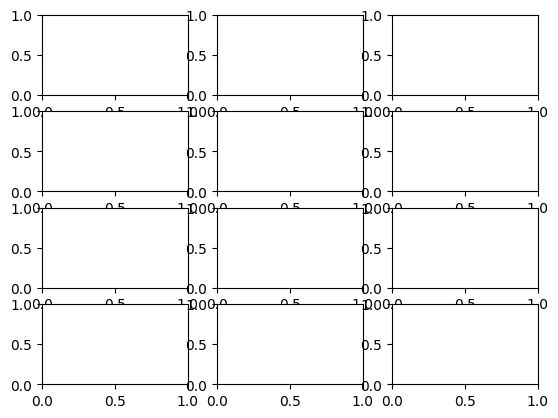

In [57]:
fig,ax = plt.subplots(nrows = 4, ncols = 3)
ax = np.array(ax).flatten()
ax[0].set_xlabel('haha')

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_11628/2387067119.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdf" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('fig/FT_compare.pdf',pdf = True)


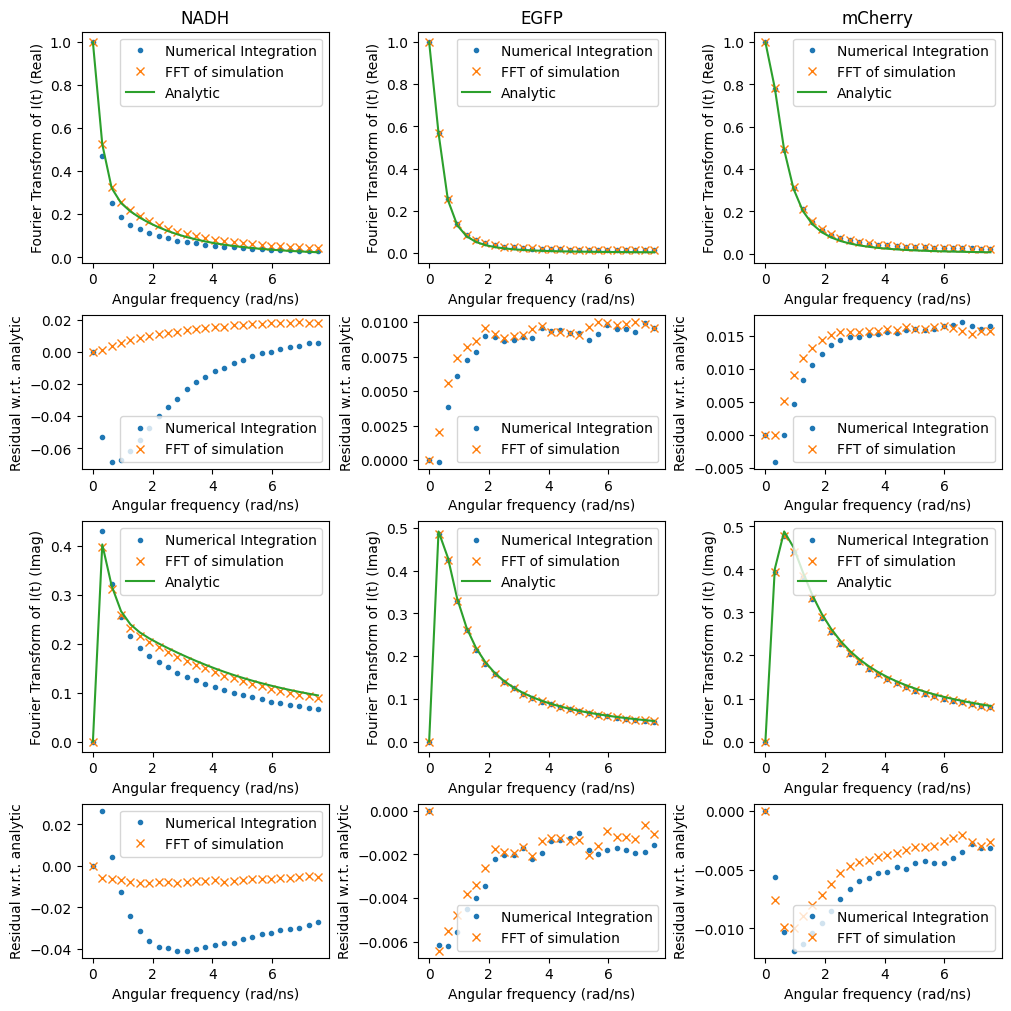

In [73]:
sim_list = [NADH,EGFP,mCherry]
sim_name = ['NADH','EGFP','mCherry']
fig,ax = plt.subplots(nrows = 4, ncols = 3,figsize = (10,10),gridspec_kw={'height_ratios': [3, 2,3,2]},constrained_layout = True)
ax = np.array(ax).flatten()
for n in range(3):
    sim = sim_list[n]
    W,Y = np.meshgrid(sim.w[:190],sim.y[15:]) 
    W,T = np.meshgrid(sim.w[:190],sim.t[:-15])
    # #W,K = np.meshgrid(sim.w[:190],sim.ker)
    # y_true= exp2(sim.t,sim.amp[0],*sim.tau)
    # #W,Y = np.meshgrid(sim.w[:190],y_true[:]) 
    # phasor = np.fft.fft(y_true)/np.sum(y_true)
    # phasor.imag*=-1
    FT = lambda Y: np.sum(np.cos(T*W)*Y+1j*np.sin(T*W)*Y,axis = 0)/np.sum(sim.y[15:]) #numerical integration for trimmed data
    phasor_true = multi_exp_FT(sim.w[:25],sim.amp,sim.tau)
    #real part
    ax[n].plot(sim.w[:25],np.real(FT(Y)[:25]),'.',label = 'Numerical Integration')
    ax[n].plot(sim.w[:25],sim.phasor.real[:25],'x',label = 'FFT of simulation')
    ax[n].plot(sim.w[:25],phasor_true.real,label = 'Analytic')
    #residual of real part
    ax[n+3].plot(sim.w[:25],np.real(FT(Y)[:25])-phasor_true.real,'.',label = 'Numerical Integration')
    ax[n+3].plot(sim.w[:25],sim.phasor.real[:25]-phasor_true.real,'x',label = 'FFT of simulation')
    #imag part
    ax[n+6].plot(sim.w[:25],np.imag(FT(Y)[:25]),'.',label = 'Numerical Integration')
    ax[n+6].plot(sim.w[:25],sim.phasor.imag[:25],'x',label = 'FFT of simulation')
    ax[n+6].plot(sim.w[:25],phasor_true.imag,label = 'Analytic')
    #residual of imag part
    ax[n+9].plot(sim.w[:25],np.imag(FT(Y)[:25])-phasor_true.imag,'.',label = 'Numerical Integration')
    ax[n+9].plot(sim.w[:25],sim.phasor.imag[:25]-phasor_true.imag,'x',label = 'FFT of simulation')


    ax[n].set_title(sim_name[n])
    ax[n].set_ylabel('Fourier Transform of I(t) (Real)')
    ax[n+3].set_ylabel('Residual w.r.t. analytic')
    ax[n+6].set_ylabel('Fourier Transform of I(t) (Imag)')
    ax[n+9].set_ylabel('Residual w.r.t. analytic')
for n in range(12):
    ax[n].set_xlabel('Angular frequency (rad/ns)')
    ax[n].legend()
plt.tight_layout
plt.savefig('fig/FT_compare.pdf',format = 'pdf')

### Decomposition of amplitudes with known lifetimes

In [4]:
EGFP = Simulation([0.503,0.497],[3.07,2.43])

With known lifetimes, fractional intensity can be solved as a system of linear eqations:
$$\begin{array}{c}
   \sum_i  f_i = 1 \\
   \sum_i  f_i/(1+(\omega_j\tau_i)^2) = g_j  \\
   \sum_i  f_i \cdot \omega_j\tau_i/(1+(\omega_j\tau_i)^2) = s_j
   \end{array}$$

- $j$ denotes the $j$ th phasor obtained from angular frequency $\omega_j$
- $i$ denotes the $i$ th component in the exponential (fractional intensity $f_i$ and lifetime $\tau_i$)
- $g$ and $s$ are the real and imaginary components of phasor respectively

if $\tau_i$ are known in advance, this is a linear system of equations

In [82]:
sim = EGFP
def f_A_solve(w,phasor,tau):
    '''This solves for fractional intensity, then convert to amplitude, with known lifetimes
       Input:
       w        angular frequency
       phasor   phasor array
       tau      lifetime array'''
    w = w[1:len(tau)]
    W,T = np.meshgrid(tau,w) 
    #only fundamental frequency is needed for 2 components
    M = np.array([[1,1],1/((W*T)**2+1)[0]]) 
    M_inv = np.linalg.inv(M)
    y = np.array([1,phasor.real[1]])
    f = np.dot(M_inv,y)
    A = NADH.A_solve(list(f)+tau) #uses the function from Phasor object,  can be applied to objects with same number of lifetime components only
    return A
for sim in sim_list:    
    print('f_A_solve:',f_A_solve(sim.w,sim.phasor,sim.tau), 'true:' ,sim.amp)

f_A_solve: [0.75242391 0.24757609] true: [0.75 0.25]
f_A_solve: [0.48466585 0.51533415] true: [0.503 0.497]
f_A_solve: [0.82993749 0.17006251] true: [0.83 0.17]


In [85]:
A_list = np.zeros((3,len(sim.phasor_data),2))
for n in range(3): 
    sim = sim_list[n]
    for i in range(len(sim.phasor_data)): #repeat sim data
        A_list[n,i] = f_A_solve(sim.w,sim.phasor_data[i],sim.tau)


In [91]:
EGFP.amp

array([0.503, 0.497])

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_11628/404541237.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


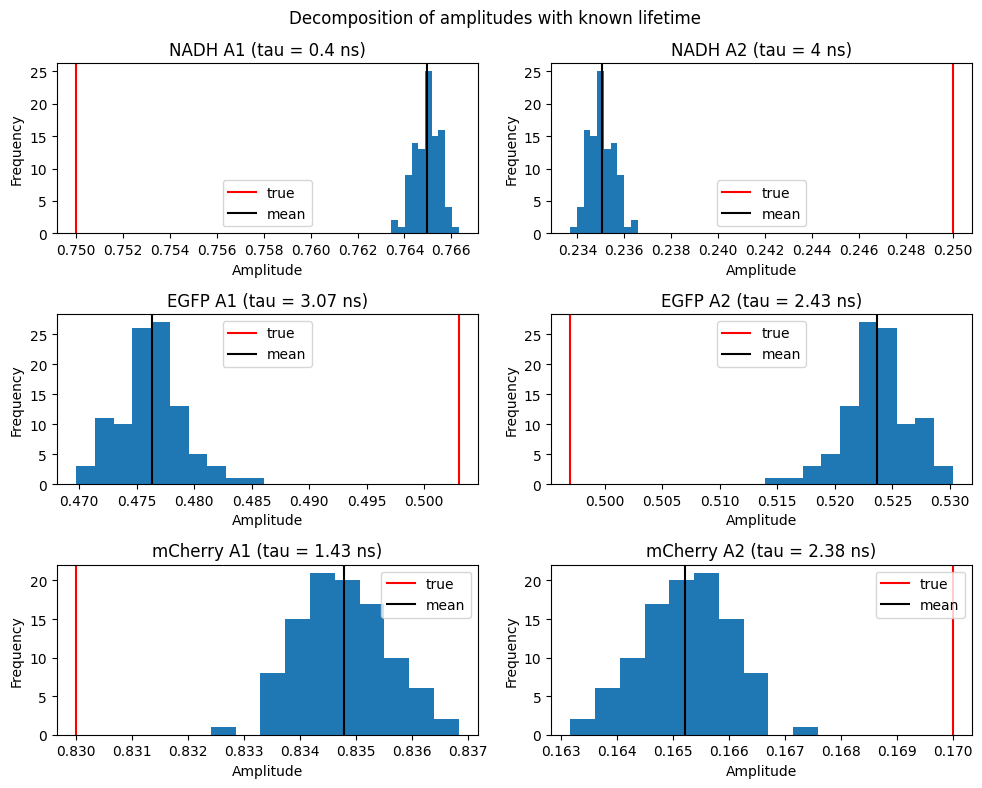

In [108]:
fig,ax = plt.subplots(nrows = 3,ncols = 2,figsize= (10,8),constrained_layout = True)
plt.suptitle('Decomposition of amplitudes with known lifetime')
for i in range(3):
    for j in range(2):
        ax[i,j].hist(A_list[i,:,j])
        ax[i,j].set_title(sim_name[i]+f' A{j+1} (tau = {sim_list[i].tau[j]} ns)')
        ax[i,j].set_xlabel('Amplitude')
        ax[i,j].set_ylabel('Frequency')
        ax[i,j].axvline(sim_list[i].amp[j],c = 'r',label = 'true')
        ax[i,j].axvline(np.mean(A_list[i,:,j]),c = 'k',label = 'mean')
        ax[i,j].legend()
plt.savefig('fig/f_A_solve.pdf',format = 'pdf')


In [39]:
def phasor_solve(w,phasor,n=2,num = False,guess=None):
    '''Solve for samplitudes and lifetimes from simulated phasor coordinates
       Input: w        angular frequency array
              phasor   output from phasor_fft
              n        number of components (Default 2)
              num      True for numerical solution, False for analytic solution
              guess    guess for numerical solution'''
    # Define the variables and symbols
    f= symbols('f1:%d' % (n+1)) #amplitudes
    t = symbols('t1:%d' % (n+1)) #lifetimes

    equations = [sum([f[j]for j in range(n)])-1]

    # Generate the equations using different angular frequencies
    for i in range(1,2*n):
        equation = sum([f[j]/ ((w[i] * t[j])**2 + 1) for j in range(n)]) - np.real(phasor)[i] #g coordinate of phasor
        equations.append(equation)
        equation = sum([f[j]*t[j]*w[i]/ ((w[i] * t[j])**2 + 1) for j in range(n)]) - np.imag(phasor)[i] #s coordinate of phasor
        equations.append(equation)

    # Solve the system of equations
    equations = equations[:2*n]
    if num == True:
        solution = nsolve(equations,[n for n in f]+[n for n in t],guess, solver='bisect')
        solution = np.concatenate(np.array(solution).astype(float)) #1d array
    else:
        solution = solve(equations)[0]
        solution = [abs(float(v)) for v in solution.values()]#convert symbols to string
    return solution

In [24]:
soln

[0.027581364787745245,
 0.9724186352122548,
 0.8217163498914972,
 2.8236602659826953]

In [29]:
phasor_true = multi_exp_FT(sim.w,sim.amp,sim.tau)

In [47]:
np.dot(EGFP.phasor-phasor_true,EGFP.phasor-phasor_true)

(0.027943039636217058+0.00011657311598876053j)

In [52]:
sim = EGFP
soln = phasor_solve(sim.w,EGFP.phasor,num=True,guess = [0.9,0.1,2.6,4.03])#list((sim.amp*sim.tau)/np.sum(sim.amp*sim.tau))+sim.tau)
Phasor.A_funcs_list(sim)
print(Phasor.A_solve(sim,soln),soln[2:])

[0.92337631 0.07662369] [2.56065045 4.61594708]


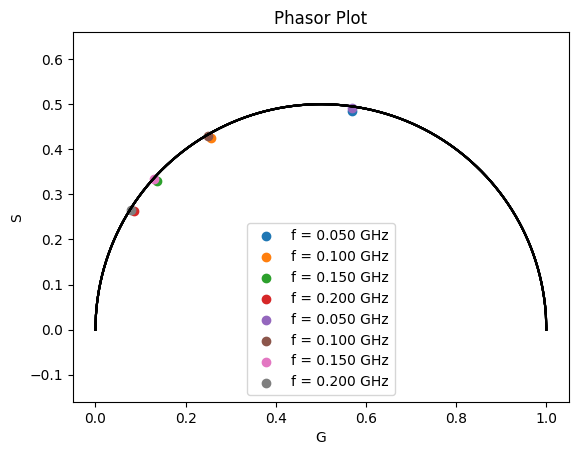

In [30]:
fig,ax = plt.subplots()
phasor_plot(ax,EGFP.w[1:5],EGFP.phasor[1:5])
phasor_plot(ax,EGFP.w[1:5],phasor_true[1:5])

### COBYLA method for more accurate decomposition

Constrained Optimization BY Linear Approximation

In [ ]:
def exp_fit(func,tdata,ydata,guess,end = int((15/20*380)),bg = 10, run_time = 20*60,weights = None,method = 'leastsq'):
    '''use least-square fit for given exponential function (exp1 or exp2)
       Inputs:
       func      exp function to be fitted 
       tdata     time array (non-trimmed)
       ydata     photon count (non-trimmed)
       guess     guess intial parameters for fitting
       end       trim the end point to avoid low count statistics
       bg        background count per s
       run_time  run_time (s)
       weights   weights for the data points of the fit (1/yerr)
       Outputs:
       result        lmfit result
       params_opt    fitted parameters
       chi2_red      reduced chi2
       fit_report    fit_report from lmfit
       '''
    model = Model(func)
    params = Parameters()
    # Get the parameter names and default values from the input function
    params_name = inspect.signature(func).parameters
    params_name = list(params_name.keys())[1:]  # Exclude 'x' from parameters
    for i,name in enumerate(params_name):
    # Add initial guess value for the parameter
        params.add(name,value=guess[i],min = 0)

    #Trim and scale data for fitting
    ydata = ydata-np.full(len(ydata),int(bg*run_time/len(tdata)))#subtract background from each bin
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    ydata = ydata/ydata[0] # scale y data such that the beginning is 1 

    
    result = model.fit(ydata, params, t=tdata,weights = weights,method = method) #perform least squares fit
    params_opt = result.params #optimized params
    chi2= result.chisqr #chi squared
    chi2_red = result.chisqr/(len(tdata)-len(params))
    fit_report = result.fit_report()
    return result, params_opt, chi2_red, fit_report

In [ ]:
for sim in [NADH,EGFP,mCherry]:
    sim.multi_exp_data()
    y_noiseless = exp2(sim.t,sim.amp[0],*sim.tau)
    y_noise = sim.y2
    weights = np.sqrt(sim.y)[np.argmax(y_noise):int((15/20*380))]
    result, params_opt, chi2_red, fit_report = exp_fit(exp2,sim.t,y_noise,[sim.amp[0]]+sim.tau
    ,weights = weights,method = 'cobyla') #use fitting method 'cobyla'
    print(fit_report)

[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 49
    # data points      = 275
    # variables        = 3
    chi-square         = 4.55782000
    reduced chi-square = 0.01675669
    Akaike info crit   = -1121.47983
    Bayesian info crit = -1110.62952
[[Variables]]
    A1:    0.75010077 +/- 5.4347e-04 (0.07%) (init = 0.75)
    tau1:  0.39763206 +/- 4.5858e-04 (0.12%) (init = 0.4)
    tau2:  3.99820758 +/- 0.01170211 (0.29%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = 0.897
    C(A1, tau1)   = 0.863
    C(tau1, tau2) = 0.706
[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 70
    # data points      = 275
    # variables        = 3
    chi-square         = 21.9294802
    reduced chi-square = 0.08062309
    Akaike info crit   = -689.458290
    Bayesian info crit = -678.607977
[[Variables]]
    A1:    0.50231824 +/- 0.14769553 (29.40%) (init 

In [ ]:
sim = EGFP
results = [] #list to store ModelResult objects
for i in range(100):
    sim.multi_exp_data()
    y_noiseless = exp2(sim.t,sim.amp[0],*sim.tau)
    y_noise = sim.y2
    weights = np.sqrt(sim.y2)[np.argmax(sim.y2):int((15/20*380))]
    result, params_opt, chi2_red, fit_report = exp_fit(exp2,sim.t,y_noise,[sim.amp[0]]+sim.tau
    ,weights = weights,method = 'cobyla') #use fitting method 'cobyla'
    print(fit_report)
    results.append(result)

In [ ]:
info_df, par_df = fit_df(results) #create fit and parameter datafame using results list

In [107]:
NADH.info_df

,chisqr,redchi,_val,init_value,stderr,correl
0,6.271532,0.023057,"[0.75, 0.406, 4.01]","[0.75, 0.4, 4]","[0.000639, 0.000541, 0.0138]","[{'tau1': '0.863', 'tau2': '0.896'}, {'A1': '0..."
1,4.599273,0.016909,"[0.751, 0.402, 4.02]","[0.75, 0.4, 4]","[0.000544, 0.000459, 0.0118]","[{'tau1': '0.863', 'tau2': '0.895'}, {'A1': '0..."
2,5.285444,0.019432,"[0.75, 0.399, 4]","[0.75, 0.4, 4]","[0.000587, 0.000493, 0.0127]","[{'tau1': '0.864', 'tau2': '0.897'}, {'A1': '0..."
3,5.326808,0.019584,"[0.75, 0.401, 4]","[0.75, 0.4, 4]","[0.000592, 0.000497, 0.0128]","[{'tau1': '0.865', 'tau2': '0.898'}, {'A1': '0..."
4,9.884173,0.036339,"[0.751, 0.4, 4]","[0.75, 0.4, 4]","[0.000802, 0.000673, 0.0173]","[{'tau1': '0.864', 'tau2': '0.897'}, {'A1': '0..."
...,...,...,...,...,...,...
95,8.898133,0.032714,"[0.75, 0.402, 4.02]","[0.75, 0.4, 4]","[0.000759, 0.00064, 0.0164]","[{'tau1': '0.864', 'tau2': '0.896'}, {'A1': '0..."
96,5.006991,0.018408,"[0.75, 0.401, 4]","[0.75, 0.4, 4]","[0.00057, 0.00048, 0.0123]","[{'tau1': '0.864', 'tau2': '0.896'}, {'A1': '0..."
97,6.832312,0.025119,"[0.749, 0.397, 4]","[0.75, 0.4, 4]","[0.000673, 0.000563, 0.0145]","[{'tau1': '0.867', 'tau2': '0.899'}, {'A1': '0..."
98,5.896135,0.021677,"[0.75, 0.396, 4]","[0.75, 0.4, 4]","[0.000617, 0.000517, 0.0133]","[{'tau1': '0.864', 'tau2': '0.897'}, {'A1': '0..."


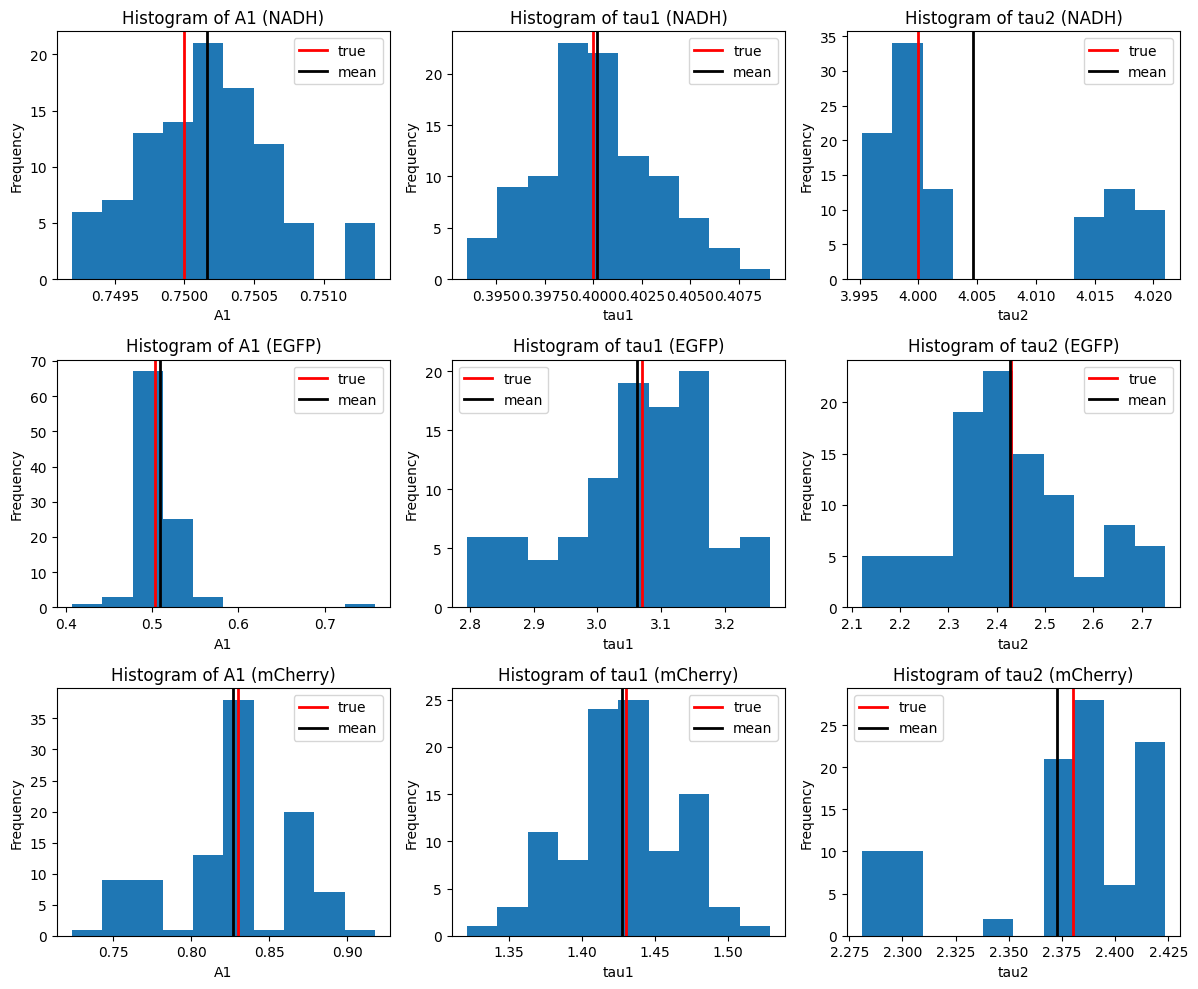

<Figure size 640x480 with 0 Axes>

In [104]:

# Create subplots with the desired number of rows and columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
axes = np.array(axes).flatten()
# Iterate over each column in the DataFrame
for n in range(3):
    sim = [NADH,EGFP,mCherry][n]
    name = ['NADH','EGFP','mCherry'][n]
    true_list = [sim.amp[0]]+sim.tau
    for idx, column in enumerate(sim.val_df):
        i = idx+3*n #index of the subplot
        # Plot the histogram on the corresponding axis
        axes[i].hist(sim.val_df[column], bins=10)  # Adjust the number of bins as needed
        axes[i].axvline(true_list[idx].real,lw = 2,c = 'r',label = 'true')
        axes[i].axvline(np.mean(sim.val_df[column]),lw = 2,c = 'k',label = 'mean')
        # Set the title and labels for the plot
        axes[i].set_title(f"Histogram of {column} ({name})")
        axes[i].set_xlabel(column)

    
        axes[i].set_ylabel("Frequency")
        axes[i].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('fig/COBYLA_fit.pdf',format = 'pdf')